In [1]:
import os

In [2]:
# hyperparameters


# trainDataset = 'taaghche'

trainDataset = 'stocks'
trainDatasetFile = 'sentiment'
# trainDatasetFile = 'signal'


In [3]:
# %%capture
!mkdir dataset
!wget https://ahmadian.me/final-dataset/taaghche.csv -O dataset/taaghche.csv

!wget https://ahmadian.me/final-dataset/stocks-test-sentiment.csv -O dataset/stocks-test-sentiment.csv
!wget https://ahmadian.me/final-dataset/stocks-test-signal.csv -O dataset/stocks-test-signal.csv
!wget https://ahmadian.me/final-dataset/stocks-train-sentiment.csv -O dataset/stocks-train-sentiment.csv
!wget https://ahmadian.me/final-dataset/stocks-train-signal.csv -O dataset/stocks-train-signal.csv

--2022-07-05 19:10:23--  https://ahmadian.me/final-dataset/taaghche.csv
Resolving ahmadian.me (ahmadian.me)... 157.90.0.201
Connecting to ahmadian.me (ahmadian.me)|157.90.0.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22056405 (21M) [text/csv]
Saving to: ‘dataset/taaghche.csv’

dataset/taaghche.cs 100%[===================>]  21.03M  13.4MB/s    in 1.6s    

2022-07-05 19:10:25 (13.4 MB/s) - ‘dataset/taaghche.csv’ saved [22056405/22056405]

--2022-07-05 19:10:26--  https://ahmadian.me/final-dataset/stocks-test-sentiment.csv
Resolving ahmadian.me (ahmadian.me)... 157.90.0.201
Connecting to ahmadian.me (ahmadian.me)|157.90.0.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 287771 (281K) [text/csv]
Saving to: ‘dataset/stocks-test-sentiment.csv’

dataset/stocks-test 100%[===================>] 281.03K   635KB/s    in 0.4s    

2022-07-05 19:10:26 (635 KB/s) - ‘dataset/stocks-test-sentiment.csv’ saved [287771/287771]

--2022-07-05 

In [4]:
# %%capture
!pip install -qU hazm
!pip install -qU clean-text[gpl]

     |████████████████████████████████| 316 kB 5.3 MB/s 
     |████████████████████████████████| 233 kB 35.8 MB/s 
     |████████████████████████████████| 1.4 MB 35.6 MB/s 
     |████████████████████████████████| 175 kB 5.0 MB/s 
     |████████████████████████████████| 53 kB 1.4 MB/s 
     |████████████████████████████████| 235 kB 48.7 MB/s 


In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import hazm
from cleantext import clean

import plotly.express as px
import plotly.graph_objects as go

from tqdm.notebook import tqdm

import os
import re
import json
import copy
import collections
import matplotlib.pyplot as plt

In [7]:
if trainDataset == 'taaghche':
    data = pd.read_csv('dataset/taaghche.csv', encoding='utf-8')
    data = data[['comment', 'rate']]


    # handle some conflicts with the dataset structure
    # you can find a reliable solution, for the sake of the simplicity
    # I just remove these bad combinations!
    data['rate'] = data['rate'].apply(lambda r: r if r < 6 else None)

    data = data.dropna(subset=['rate'])
    data = data.dropna(subset=['comment'])
    data = data.drop_duplicates(subset=['comment'], keep='first')
    data = data.reset_index(drop=True)


    # calculate the length of comments based on their words
    data['comment_len_by_words'] = data['comment'].apply(lambda t: len(hazm.word_tokenize(t)))


    def rate_to_label(rate, threshold=3.0):
        if rate <= threshold:
            return 'negative'
        else:
            return 'positive'


    data['label'] = data['rate'].apply(lambda t: rate_to_label(t, 3.0))
    data.head()
elif trainDataset == 'stocks':
    if trainDatasetFile == 'sentiment':
        data = pd.read_csv('dataset/stocks-train-sentiment.csv', encoding='utf-8')
    else:
        data = pd.read_csv('dataset/stocks-train-signal.csv', encoding='utf-8')


    data = data[['message', 'sentiment_label']]
    data = data.rename(columns={"message": "comment", "sentiment_label": "label_id"})


    # data = data[data['label_id'] != 0]

    data['label'] = data['label_id']
    data = data.replace({'label': {0: 'neutral', 1: 'positive', 2: 'negative'}})


    # calculate the length of comments based on their words
    data['comment_len_by_words'] = data['comment'].apply(lambda t: len(hazm.word_tokenize(t)))




    if trainDatasetFile == 'sentiment':
        dataTest = pd.read_csv('dataset/stocks-test-sentiment.csv', encoding='utf-8')
    else:
        dataTest = pd.read_csv('dataset/stocks-test-signal.csv', encoding='utf-8')

    dataTest = dataTest[['message', 'sentiment_label']]
    dataTest = dataTest.rename(columns={"message": "comment", "sentiment_label": "label_id"})


    # dataTest = dataTest[dataTest['label_id'] != 0]

    dataTest['label'] = dataTest['label_id']
    dataTest = dataTest.replace({'label': {0: 'neutral', 1: 'positive', 2: 'negative'}})


    # calculate the length of comments based on their words
    dataTest['comment_len_by_words'] = dataTest['comment'].apply(lambda t: len(hazm.word_tokenize(t)))




labels = list(sorted(data['label'].unique()))

In [8]:
def data_gl_than(data, less_than=100.0, greater_than=0.0, col='comment_len_by_words'):
    data_length = data[col].values

    data_glt = sum([1 for length in data_length if greater_than < length <= less_than])

    data_glt_rate = (data_glt / len(data_length)) * 100

    print(f'Texts with word length of greater than {greater_than} and less than {less_than} includes {data_glt_rate:.2f}% of the whole!')

In [9]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()
    
    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )

    # cleaning htmls
    text = cleanhtml(text)
    
    # normalizing
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)
    
    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    text = wierd_pattern.sub(r'', text)
    
    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)
    
    return text

In [10]:
data_gl_than(data, 256, 3)


minlim, maxlim = 3, 256


# remove comments with the length of fewer than three words
data['comment_len_by_words'] = data['comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else None)
data = data.dropna(subset=['comment_len_by_words'])
data = data.reset_index(drop=True)


# cleaning comments
data['cleaned_comment'] = data['comment'].apply(cleaning)


# calculate the length of comments based on their words
data['cleaned_comment_len_by_words'] = data['cleaned_comment'].apply(lambda t: len(hazm.word_tokenize(t)))

# remove comments with the length of fewer than three words
data['cleaned_comment_len_by_words'] = data['cleaned_comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else len_t)
data = data.dropna(subset=['cleaned_comment_len_by_words'])
data = data.reset_index(drop=True)

data.head()


data = data[['cleaned_comment', 'label']]
data.columns = ['comment', 'label']
data.head()


if trainDataset == 'stocks':
    data_gl_than(dataTest, 256, 3)


    minlim, maxlim = 3, 256


    # remove comments with the length of fewer than three words
    dataTest['comment_len_by_words'] = dataTest['comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else None)
    dataTest = dataTest.dropna(subset=['comment_len_by_words'])
    dataTest = dataTest.reset_index(drop=True)


    # cleaning comments
    dataTest['cleaned_comment'] = dataTest['comment'].apply(cleaning)


    # calculate the length of comments based on their words
    dataTest['cleaned_comment_len_by_words'] = dataTest['cleaned_comment'].apply(lambda t: len(hazm.word_tokenize(t)))

    # remove comments with the length of fewer than three words
    dataTest['cleaned_comment_len_by_words'] = dataTest['cleaned_comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else len_t)
    dataTest = dataTest.dropna(subset=['cleaned_comment_len_by_words'])
    dataTest = dataTest.reset_index(drop=True)

    dataTest.head()


    dataTest = dataTest[['cleaned_comment', 'label']]
    dataTest.columns = ['comment', 'label']
    dataTest.head()

Texts with word length of greater than 3 and less than 256 includes 99.04% of the whole!
Texts with word length of greater than 3 and less than 256 includes 94.37% of the whole!


In [11]:
new_data = data

if trainDataset == 'stocks':
    new_data_test = dataTest

In [12]:
# split data to train valid test
new_data['label_id'] = new_data['label'].apply(lambda t: labels.index(t))

if trainDataset == 'stocks':
    new_data_test['label_id'] = new_data_test['label'].apply(lambda t: labels.index(t))
    valid, test = train_test_split(new_data_test, test_size=0.1, random_state=1, stratify=new_data_test['label'])
    train = data
else:
    train, test = train_test_split(new_data, test_size=0.1, random_state=1, stratify=new_data['label'])
    train, valid = train_test_split(train, test_size=0.1, random_state=1, stratify=train['label'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

x_train, y_train = train['comment'].values.tolist(), train['label_id'].values.tolist()
x_valid, y_valid = valid['comment'].values.tolist(), valid['label_id'].values.tolist()
x_test, y_test = test['comment'].values.tolist(), test['label_id'].values.tolist()

print(train.shape)
print(valid.shape)
print(test.shape)

label_list = ['negative', 'positive', 'neutral']

(206, 3)
(60, 3)
(7, 3)



 Accuracy:  0.42727272727272725

Classification Report

               precision    recall  f1-score   support

           0       0.00      0.00      0.00        48
           1       0.43      0.97      0.59        39
           2       0.43      0.39      0.41        23

    accuracy                           0.43       110
   macro avg       0.29      0.46      0.33       110
weighted avg       0.24      0.43      0.30       110




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetric

(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

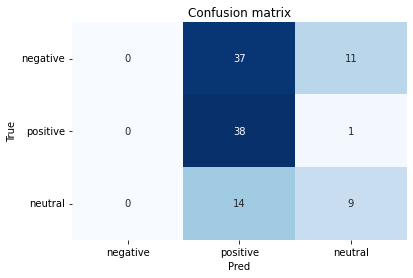

In [13]:
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer

modifyFeatures = {
    'افزایش': 10,
    'رشد': 10,
    'بهبود': 10,
    'مثبت': 10,
    'صف خرید': 10,
    'خرید': 10,
    
    'کاهش': 10,
    'افت': 10,
    'حاصل نکرده': 10,
    'منفی': 10,
    'صف فروش': 10,
    'ریزش': 10,
}

train = pd.concat([train, valid, test])

commentsData = train['comment'].to_numpy()
yData = [label_list.index(label) for label in train['label'].values]

# Building a TF IDF matrix out of the corpus of reviews

td = TfidfVectorizer(max_features = 4500)
commentsData = td.fit_transform(commentsData).toarray()

features = td.get_feature_names()

for key in modifyFeatures:
    if key in features:
        idx = features.index(key)
        for comment in commentsData:
          comment[idx] *= modifyFeatures[key]

# Splitting into training & test subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, yData = train_test_split(commentsData, yData, test_size = 0.4,
                                                    random_state = 0, shuffle=False)

# Training the classifier & predicting on test data
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

#  generate yhat
y_pred = classifier.predict(X_test)

# Classification metrics
from sklearn.metrics import accuracy_score, classification_report
classification_report = classification_report(yData, y_pred)

print('\n Accuracy: ', accuracy_score(yData, y_pred))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)
print()



cm = metrics.confusion_matrix(yData, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=label_list, 
       yticklabels=label_list, title="Confusion matrix")
plt.yticks(rotation=0)